###О задании

На занятиях мы подробно обсуждали метод опорных векторов (SVM). В базовой версии в нём нет чего-то особенного — мы всего лишь используем специальную функцию потерь, которая не требует устремлять отступы к бесконечности; ей достаточно, чтобы отступы были не меньше +1. Затем мы узнали, что SVM можно переписать в двойственном виде, который, позволяет заменить скалярные произведения объектов на ядра. Это будет соответствовать построению модели в новом пространстве более высокой размерности, координаты которого представляют собой нелинейные модификации исходных признаков.

Ядровой SVM, к сожалению, довольно затратен по памяти (нужно хранить матрицу Грама размера $d \times d$) и по времени (нужно решать задачу условной оптимизации с квадратичной функцией, а это не очень быстро). Мы обсуждали, что есть способы посчитать новые признаки $\tilde \varphi(x)$ на основе исходных так, что скалярные произведения этих новых $\langle \tilde \varphi(x), \tilde \varphi(z) \rangle$ приближают ядро $K(x, z)$.

Мы будем исследовать аппроксимации методом Random Fourier Features (RFF, также в литературе встречается название Random Kitchen Sinks) для гауссовых ядер. Будем использовать формулы, которые немного отличаются от того, что было на лекциях (мы добавим сдвиги внутрь тригонометрических функций и будем использовать только косинусы, потому что с нужным сдвигом косинус превратится в синус):
$$\tilde \varphi(x) = (
\cos (w_1^T x + b_1),
\dots,
\cos (w_n^T x + b_n)
),$$
где $w_j \sim \mathcal{N}(0, 1/\sigma^2)$, $b_j \sim U[-\pi, \pi]$.

На новых признаках $\tilde \varphi(x)$ мы будем строить любую линейную модель.

Можно считать, что это некоторая новая парадигма построения сложных моделей. Можно направленно искать сложные нелинейные закономерности в данных с помощью градиентного бустинга или нейронных сетей, а можно просто нагенерировать большое количество случайных нелинейных признаков и надеяться, что быстрая и простая модель (то есть линейная) сможет показать на них хорошее качество. В этом задании мы изучим, насколько работоспособна такая идея.

### Алгоритм

Вам потребуется реализовать следующий алгоритм:
1. Понизить размерность выборки до new_dim с помощью метода главных компонент.
2. Для полученной выборки оценить гиперпараметр $\sigma^2$ с помощью эвристики (рекомендуем считать медиану не по всем парам объектов, а по случайному подмножеству из где-то миллиона пар объектов): $$\sigma^2 = \text{median}_{i, j = 1, \dots, \ell, i \neq j} \left\{\sum_{k = 1}^{d} (x_{ik} - x_{jk})^2 \right\}$$
3. Сгенерировать n_features наборов весов $w_j$ и сдвигов $b_j$.
4. Сформировать n_features новых признаков по формулам, приведённым выше.
5. Обучить линейную модель (логистическую регрессию или SVM) на новых признаках.
6. Повторить преобразования (PCA, формирование новых признаков) к тестовой выборке и применить модель.

# Машинное обучение, ФКН ВШЭ

## Практическое задание 8. Метод опорных векторов и аппроксимация ядер

### Общая информация

Дата выдачи: 04.02.2023

Мягкий дедлайн: 23:59MSK 20.02.2023

Жесткий дедлайн: 23:59MSK 26.02.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимальная оценка за работу (без учёта бонусов) — 10 баллов.

Сдавать задание после указанного жёсткого срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-08-random-features-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### нужно ускориться (increase speed, accelerate, be fast etc.)

https://medium.com/analytics-vidhya/how-to-install-and-run-thundersvm-in-google-colab-de1fe49eef85

In [1]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
2

--2023-02-17 14:50:15--  https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Resolving developer.nvidia.com (developer.nvidia.com)... 152.195.19.142
Connecting to developer.nvidia.com (developer.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://developer.nvidia.com/downloads/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb [following]
--2023-02-17 14:50:15--  https://developer.nvidia.com/downloads/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
Reusing existing connection to developer.nvidia.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://developer.download.nvidia.com/compute/cuda/9.0/secure/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64.deb?eM9Xb3AWN7XPOPcFSIJ6vABbud87phjKAPpq5DqScPisiTMnGlF7U6QCp6eCccdKi0cpTVHAt

2

In [2]:
!ls  # Check if required cuda 9.0 amd64-deb file is downloaded

cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb  sample_data


In [3]:
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb

Selecting previously unselected package cuda-repo-ubuntu1704-9-0-local.
(Reading database ... 128126 files and directories currently installed.)
Preparing to unpack cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb ...
Unpacking cuda-repo-ubuntu1704-9-0-local (9.0.176-1) ...
Setting up cuda-repo-ubuntu1704-9-0-local (9.0.176-1) ...


In [4]:
!ls /var/cuda-repo-9-0-local | grep .pub

7fa2af80.pub


In [5]:
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub

OK


In [6]:
!apt-get update

Get:1 file:/var/cuda-repo-9-0-local  InRelease
Ign:1 file:/var/cuda-repo-9-0-local  InRelease
Get:2 file:/var/cuda-repo-9-0-local  Release [574 B]
Get:2 file:/var/cuda-repo-9-0-local  Release [574 B]
Get:3 file:/var/cuda-repo-9-0-local  Release.gpg [819 B]
Get:3 file:/var/cuda-repo-9-0-local  Release.gpg [819 B]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:6 file:/var/cuda-repo-9-0-local  Packages [15.8 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:10 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:12 http://archive.ubuntu.com/ubuntu f

In [7]:
!sudo apt-get install cuda-9.0

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'cuda-9-0' for regex 'cuda-9.0'
Note, selecting 'libcuda-9.0-1' for regex 'cuda-9.0'
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  cuda-command-line-tools-9-0 cuda-core-9-0 cuda-cublas-9-0
  cuda-cublas-dev-9-0 cuda-cudart-9-0 cuda-cudart-dev-9-0 cuda-cufft-9-0
  cuda-cufft-dev-9-0 cuda-curand-9-0 cuda-curand-dev-9-0 cuda-cusolver-9-0
  cuda-cusolver-dev-9-0 cuda-cusparse-9-0 cuda-cusparse-dev-9-0
  cuda-demo-suite-9-0 cuda-documentation-9-0 cuda-driver-dev-9-0
  cuda-libraries-9-0 cuda-libraries-dev-9-0 cuda-license-9-0
  cuda-misc-headers-9-0 cuda-npp-9-0 cuda-npp-dev-9-0 cuda-nvgraph-9-0
  cuda-nvgraph-dev-9-0 cuda-nvml-dev-9-0 cuda-nvrtc-9-0 cuda-nvrtc-dev-9-0
  cuda-runtime-9-0 cuda-samples-9-0 cuda-toolkit-9-0 cuda-visual-t

In [8]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176


In [9]:
!pip install thundersvm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.4/507.4 KB 9.8 MB/s eta 0:00:00


# Тестировать алгоритм мы будем на данных Fashion MNIST. Ниже код для их загрузки и подготовки.

In [6]:
import keras
from keras.datasets import fashion_mnist
(x_train_pics, y_train), (x_test_pics, y_test) = fashion_mnist.load_data()
x_train = x_train_pics.reshape(y_train.shape[0], -1)
x_test = x_test_pics.reshape(y_test.shape[0], -1)

4422102/4422102 [==============================] - 0s 0us/step


In [7]:
print(x_train_pics.shape)
print(x_train.shape)
print(x_test_pics.shape)
print(x_test.shape)

(60000, 28, 28)
(60000, 784)
(10000, 28, 28)
(10000, 784)


In [8]:
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, MinMaxScaler

# по отдельности тоже не работает - проверял
# pipeline = Pipeline([
#     ('min_max_scaler', MinMaxScaler()),
#     ('std_scaler', StandardScaler())
# ])

# x_train = pipeline.fit_transform(x_train)
# x_test = pipeline.transform(x_test)

# x_train = x_train - np.mean(x_train, axis=0)
# x_test = x_test - np.mean(x_test, axis=0)

from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
x_train = normalizer.fit_transform(x_train)
x_test = normalizer.transform(x_test)
# почему нужно было именно отнормировать по l2 норме каждый объект - понятия не имею
# я пытался центрировать признаки, не трогая дисперсию - ничего не вышло  

In [9]:
random_state = 1337

#__Задание 1. (5 баллов)__

Реализуйте алгоритм, описанный выше. Можете воспользоваться шаблоном класса ниже или написать свой интерфейс.

Ваша реализация должна поддерживать следующие опции:
1. Возможность задавать значения гиперпараметров new_dim (по умолчанию 50) и n_features (по умолчанию 1000).
2. Возможность включать или выключать предварительное понижение размерности с помощью метода главных компонент.
3. Возможность выбирать тип линейной модели (логистическая регрессия или SVM с линейным ядром).

Протестируйте на данных Fashion MNIST, сформированных кодом выше. Если на тесте у вас получилась доля верных ответов не ниже 0.84 с гиперпараметрами по умолчанию, то вы всё сделали правильно.

In [31]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import numpy as np
from itertools import combinations
# from thundersvm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



class RFFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier_type='logreg', C=1.0):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier_type = classifier_type
        self.C = C

        if (self.classifier_type == 'logreg'):
          self.cls = LogisticRegression(random_state=random_state, n_jobs = -1, C = self.C)
        elif (self.classifier_type == 'svm'):
          self.cls = SVC(kernel = 'linear', random_state=random_state, C = self.C)

        if(self.use_PCA):
          self.pca = PCA(n_components=self.new_dim, random_state=random_state)
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, RFF, Classification) to training set.
        """
        if(self.use_PCA):
            X = self.pca.fit_transform(X)

        X_subset = X[np.random.choice(X.shape[0], 1500, replace=False)] # (~1100000 пар)
        sgm_squared = np.median([np.sum(np.square(x1 - x2)) for (x1, x2) in combinations(X_subset, r = 2)])

        self.w = np.random.normal(0, 1/sgm_squared, size=(self.n_features, X.shape[1]))
        self.b = np.random.uniform(-np.pi, np.pi, self.n_features)

        X_new = np.cos(X.dot(self.w.T) - self.b)

        self.cls.fit(X_new,y)

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if(self.use_PCA):
            X = self.pca.transform(X)
        X_new = np.cos(X.dot(self.w.T) - self.b)
        return(self.cls.predict_proba(X_new))
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if(self.use_PCA):
            X = self.pca.transform(X)
        X_new = np.cos(X.dot(self.w.T) - self.b)
        return(self.cls.predict(X_new))

In [64]:
rff = RFFPipeline()
rff.fit(x_train, y_train)

RFFPipeline()

In [66]:
print(accuracy_score(y_train, rff.predict(x_train)))
print(accuracy_score(y_test, rff.predict(x_test)))

0.8867833333333334
0.8668


# __Задание 2. (3 балла)__

###часть 1

Сравните подход со случайными признаками с обучением SVM на исходных признаках. Попробуйте вариант с обычным (линейным) SVM и с ядровым SVM. Ядровой SVM может очень долго обучаться, поэтому можно делать любые разумные вещи для ускорения: брать подмножество объектов из обучающей выборки, например.

In [ ]:
rff_svm = RFFPipeline(classifier_type = 'svm', n_features = 1000)
linear_svm = SVC(kernel = 'linear', random_state=random_state)
rbf_svm = SVC(kernel = 'rbf', random_state=random_state)
sigmoid_svm = SVC(kernel = 'sigmoid', random_state=random_state)

RFF SVM:

In [ ]:
rff_svm.fit(x_train, y_train)
rff_train_predictions = rff_svm.predict(x_train)
rff_test_predictions = rff_svm.predict(x_test)

In [ ]:
print(f'train accuracy: {accuracy_score(y_train, rff_train_predictions)}')
print(f'test accuracy: {accuracy_score(y_test, rff_test_predictions)}')

train accuracy: 0.9381166666666667
test accuracy: 0.8804


LINEAR SVM over initial features:

In [ ]:
linear_svm.fit(x_train, y_train)
ln_train_predictions = linear_svm.predict(x_train)
ln_test_predictions = linear_svm.predict(x_test)

In [ ]:
print(f'train accuracy: {accuracy_score(y_train, ln_train_predictions)}')
print(f'test accuracy: {accuracy_score(y_test, ln_test_predictions)}')

train accuracy: 0.8713333333333333
test accuracy: 0.8532


RBF SVM over initial features:

In [ ]:
rbf_svm.fit(x_train, y_train)
rbf_train_predictions = rbf_svm.predict(x_train)
rbf_test_predictions = rbf_svm.predict(x_test)

In [ ]:
print(f'train accuracy: {accuracy_score(y_train, rbf_train_predictions)}')
print(f'test accuracy: {accuracy_score(y_test, rbf_test_predictions)}')

train accuracy: 0.7110166666666666
test accuracy: 0.7007


SIGMOID SVM over initial features:



In [ ]:
sigmoid_svm.fit(x_train, y_train)
sigmoid_train_predictions = sigmoid_svm.predict(x_train)
sigmoid_test_predictions = sigmoid_svm.predict(x_test)

In [ ]:
print(f'train accuracy: {accuracy_score(y_train, sigmoid_train_predictions)}')
print(f'test accuracy: {accuracy_score(y_test, sigmoid_test_predictions)}')

train accuracy: 0.5855333333333334
test accuracy: 0.5732


выводы по части 1:


гиперпараметры для разных вариантах svm не подбирались - оцениваем всех в одинаковых условиях

рукописный rff показывает лучшее качество среди всех представленных моделей - видимо, преобразование признаков не лишено смысла 

интересно, какая аппроксимация гауссового ядра используется в этой реализации rbf ?

### часть 2

Сравните подход со случайными признаками с вариантом, в котором вы понижаете размерность с помощью PCA и обучаете градиентный бустинг. Используйте одну из реализаций CatBoost/LightGBM/XGBoost, не забудьте подобрать число деревьев и длину шага.

In [ ]:
!pip install catboost

In [8]:
import catboost as cb
cb.__version__

'1.1.1'

In [9]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [39]:
pca = PCA(n_components=50, random_state=random_state)

x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

In [32]:
# %%time
# choose = np.random.randint(0,x_train_pca.shape[0], 20000)
# CatBoostClassifier(loss_function='MultiClass',classes_count = 10,verbose=True, task_type="GPU",
#                            devices='0:1').fit(x_train_pca, y_train)
# ~ 10 sec per fold on gpu

In [ ]:
choose = np.random.randint(0,x_train_pca.shape[0], 20000)

catboost = CatBoostClassifier(
                           loss_function='MultiClass',
                           classes_count = 10,
                           verbose=False,
                           task_type="GPU",
                           devices='0:1')

catboost.grid_search(param_grid={'depth': [2,4,6,10], #[2,4,6,10]
                                 'learning_rate':[0.004, 0.03, 0.1, 0.5, 1]}, #[0.004, 0.03, 0.1, 0.5, 1]
                     X = x_train_pca[choose], y = y_train[choose])

In [15]:
catboost.get_params()

{'loss_function': 'MultiClass',
 'verbose': False,
 'classes_count': 10,
 'task_type': 'GPU',
 'devices': '0:1',
 'depth': 10,
 'learning_rate': 0.1}

In [46]:
catboost = CatBoostClassifier(
                           loss_function='MultiClass',
                           classes_count = 10,
                           verbose=False,
                           task_type="GPU",
                           devices='0:1', depth = 10, learning_rate=0.1)

In [47]:
catboost.fit(x_train_pca, y_train)

In [48]:
catboost_train_predictions = catboost.predict(x_train)
catboost_test_predictions = catboost.predict(x_test)

In [49]:
print(f'train accuracy: {accuracy_score(y_train, catboost_train_predictions)}')
print(f'test accuracy: {accuracy_score(y_test, catboost_test_predictions)}')

train accuracy: 0.15796666666666667
test accuracy: 0.1564


выводы по части 2:

catboost показывает ужасное качество (обучал с PCA на 50 и 200 новых признаков с использованием перебора глубины и lr и без, и все равно качество не выше 0.156) с чем это связано - не знаю

очевидно, rff svm справляется сильно лучше 

#__Задание 3. (2 балла)__

Проведите эксперименты:
1. Помогает ли предварительное понижение размерности с помощью PCA? 
2. Как зависит итоговое качество от n_features? Выходит ли оно на плато при росте n_features?
3. Важно ли, какую модель обучать — логистическую регрессию или SVM?

###часть 1:
сравним качесво rff svm при использовании pca и без него:

In [ ]:
%%time
rff_svm_pca = RFFPipeline(use_PCA = True).fit(x_train, y_train)

CPU times: user 17.3 s, sys: 3.5 s, total: 20.8 s
Wall time: 42.2 s


In [ ]:
%%time
pca_train_predictions = rff_svm_pca.predict(x_train)
pca_test_predictions = rff_svm_pca.predict(x_test)

CPU times: user 2.72 s, sys: 722 ms, total: 3.44 s
Wall time: 3.09 s


In [ ]:
print(f'train accuracy: {accuracy_score(y_train, pca_train_predictions)}')
print(f'test accuracy: {accuracy_score(y_test, pca_test_predictions)}')

train accuracy: 0.8853666666666666
test accuracy: 0.8653


In [ ]:
%%time
rff_svm_no_pca = RFFPipeline(use_PCA = False).fit(x_train, y_train)

CPU times: user 16.2 s, sys: 889 ms, total: 17.1 s
Wall time: 41.9 s


In [ ]:
%%time
no_pca_train_predictions = rff_svm_no_pca.predict(x_train)
no_pca_test_predictions = rff_svm_no_pca.predict(x_test)

CPU times: user 5.88 s, sys: 547 ms, total: 6.42 s
Wall time: 4.7 s


In [ ]:
print(f'train accuracy: {accuracy_score(y_train, no_pca_train_predictions)}')
print(f'test accuracy: {accuracy_score(y_test, no_pca_test_predictions)}')

train accuracy: 0.8951666666666667
test accuracy: 0.8669


применение PCA для svm не дает прироста в скорости, только незначительно понижает точность 

видимо, затраты на вычиление матрицы X_new (X.dot(W.T)) пренебрежимо малы по сравнению с затратами на остальные вычисления 

###часть 2:
сравним логистическую регрессию и svm:

In [32]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV

In [17]:
# x_train_crop = x_train[np.random.choice(x_train.shape[0], 60000, replace=False)]
# x_test_crop = x_test[np.random.choice(x_test.shape[0], 3000, replace=False)]
# y_train_crop = y_train[np.random.choice(y_train.shape[0], 60000, replace=False)]
# y_test_crop = y_test[np.random.choice(y_test.shape[0], 3000, replace=False)]

интересно, что это: 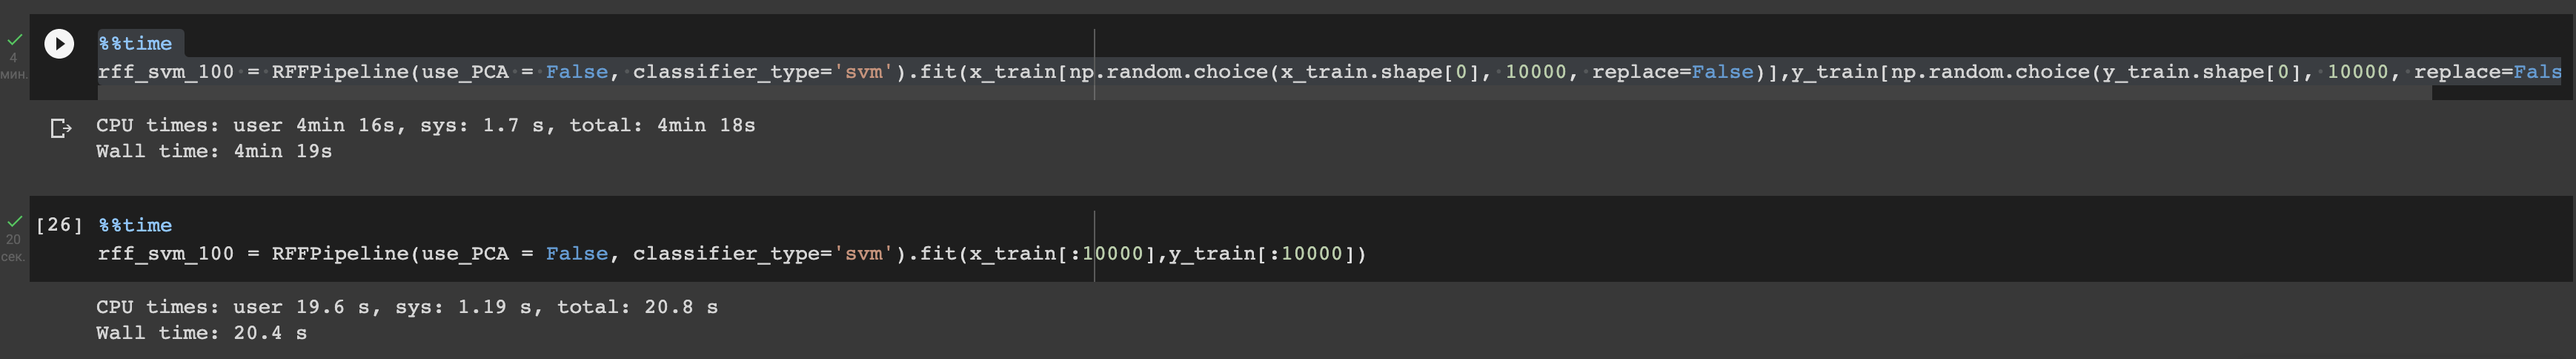

In [73]:
%%time
rff_logreg_gs = GridSearchCV(estimator = RFFPipeline(use_PCA = False, classifier_type='logreg'),
             param_grid={'C': [0.1,0.5,1,5,10,13,15,20,50,100]}, cv = 3, scoring = 'accuracy', n_jobs = -1, verbose=3, refit=False)
rff_logreg_gs.fit(x_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
CPU times: user 5.51 s, sys: 1.03 s, total: 6.54 s
Wall time: 14min 37s


GridSearchCV(cv=3, estimator=RFFPipeline(use_PCA=False), n_jobs=-1,
             param_grid={'C': [0.1, 0.5, 1, 5, 10, 13, 15, 20, 50, 100]},
             refit=False, scoring='accuracy', verbose=3)

In [74]:
rff_logreg_gs.cv_results_

{'mean_fit_time': array([58.71314112, 57.09034228, 55.93374443, 57.48826241, 55.28558286,
        55.8165187 , 55.31142314, 55.57620947, 53.83065915, 52.99589372]),
 'std_fit_time': array([0.83548263, 0.64602634, 0.43541065, 0.99863522, 0.32063512,
        0.37863762, 1.18366934, 1.91920779, 0.44720451, 0.58572171]),
 'mean_score_time': array([2.91151635, 2.3943162 , 2.29322847, 2.65838949, 2.64575839,
        2.43766594, 2.37677073, 2.24127809, 2.44501869, 1.95491854]),
 'std_score_time': array([0.42942765, 0.25850005, 0.0781098 , 0.58850573, 0.21493683,
        0.39952801, 0.20461613, 0.11070213, 0.1619712 , 0.58559835]),
 'param_C': masked_array(data=[0.1, 0.5, 1, 5, 10, 13, 15, 20, 50, 100],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.1},
  {'C': 0.5},
  {'C': 1},
  {'C': 5},
  {'C': 10},
  {'C': 13},
  {'C': 15},
  {'C': 20},
  {'C': 50},
  {'C

In [75]:
rff_logreg_gs.best_params_

{'C': 100}

c = 100 - практически выключили регуляризацию - повышение качества в районе этого значения выглядит как выброс (удачные данные) - берем с = 0.5

In [26]:
%%time
rff_logreg_best_c = RFFPipeline(use_PCA = False, classifier_type='logreg', C = 1).fit(x_train,y_train)

CPU times: user 14.3 s, sys: 657 ms, total: 14.9 s
Wall time: 45.7 s


In [27]:
%%time
rff_logreg_train_predictions = rff_logreg_best_c.predict(x_train)
rff_logreg_test_predictions = rff_logreg_best_c.predict(x_test)

CPU times: user 7.79 s, sys: 359 ms, total: 8.15 s
Wall time: 5.86 s


In [28]:
print(f'train accuracy: {accuracy_score(y_train, rff_logreg_train_predictions)}')
print(f'test accuracy: {accuracy_score(y_test, rff_logreg_test_predictions)}')

train accuracy: 0.89695
test accuracy: 0.8698


In [ ]:
%%time
for c in [0.1,0.5,1,5,10]:
    rff_svm = RFFPipeline(use_PCA = False, classifier_type='svm', C = c).fit(x_train, y_train)
    print(f'C: {c}')
    print(f'train accuracy: {accuracy_score(y_train, rff_svm.predict(x_train))}')
    print(f'test accuracy: {accuracy_score(y_test, rff_svm.predict(x_test))}')

C: 0.1
train accuracy: 0.9310333333333334
test accuracy: 0.87
C: 0.5
train accuracy: 0.9413
test accuracy: 0.8619
C: 1
train accuracy: 0.9452666666666667
test accuracy: 0.8595
C: 5
train accuracy: 0.9490833333333333
test accuracy: 0.855


In [44]:
%%time
for c in [13,15,20,50,100]:
    rff_svm = RFFPipeline(use_PCA = False, classifier_type='svm', C = c).fit(x_train, y_train)
    print(f'C: {c}')
    print(f'train accuracy: {accuracy_score(y_train, rff_svm.predict(x_train))}')
    print(f'test accuracy: {accuracy_score(y_test, rff_svm.predict(x_test))}')

C: 13
train accuracy: 0.8883666666666666
test accuracy: 0.856
C: 15
train accuracy: 0.88875
test accuracy: 0.8529
C: 20
train accuracy: 0.8908333333333334
test accuracy: 0.8538
C: 50
train accuracy: 0.8963166666666667
test accuracy: 0.8541
C: 100
train accuracy: 0.8977666666666667
test accuracy: 0.8485
CPU times: user 7min 4s, sys: 24.9 s, total: 7min 29s
Wall time: 7min 17s


In [32]:
%%time
rff_svm_best_c = RFFPipeline(use_PCA = False, classifier_type='svm', C = 0.1).fit(x_train, y_train)

CPU times: user 54 s, sys: 7.37 s, total: 1min 1s
Wall time: 1min 4s


In [33]:
%%time
rff_smv_train_predictions = rff_svm_best_c.predict(x_train)
rff_smv_test_predictions = rff_svm_best_c.predict(x_test)

CPU times: user 22.1 s, sys: 533 ms, total: 22.6 s
Wall time: 20 s


In [34]:
print(f'train accuracy: {accuracy_score(y_train, rff_smv_train_predictions)}')
print(f'test accuracy: {accuracy_score(y_test, rff_smv_test_predictions)}')

train accuracy: 0.9316
test accuracy: 0.8726


отличия в качества порядка 0.01 при всех соответсвующих значениях C - незначительно

скорость обучения svm даже на gpu ~ в 3 раза ниже, чем у регрессии на cpu 

выбор в пользу регрессии очевиден 

###часть 3:
проведем эксперименты с n_features:

In [11]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, GridSearchCV

при n_features = 10000 упираемся в memory limit exception 

In [12]:
%%time
rff_logreg_gs = GridSearchCV(estimator = RFFPipeline(use_PCA = False, classifier_type='logreg'),
             param_grid={'n_features': [100,500,1000,1500,3000,4000,5000,6000,7000]}, cv = 3, scoring = 'accuracy', n_jobs = -1, verbose=3, refit=False)
rff_logreg_gs.fit(x_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
CPU times: user 14.1 s, sys: 2.3 s, total: 16.4 s
Wall time: 39min 11s


GridSearchCV(cv=3, estimator=RFFPipeline(use_PCA=False), n_jobs=-1,
             param_grid={'n_features': [100, 500, 1000, 1500, 3000, 4000, 5000,
                                        6000, 7000]},
             refit=False, scoring='accuracy', verbose=3)

In [14]:
rff_logreg_gs.cv_results_

{'mean_fit_time': array([ 27.85690983,  41.47800906,  64.05078904,  85.21455224,
        165.08231457, 215.85326711, 251.86182149, 294.54960219,
        324.57312353]),
 'std_fit_time': array([ 0.43854003,  0.3181699 ,  0.86481513,  2.64633248,  7.17313566,
         8.01999707,  8.21452732,  6.17237496, 25.63339716]),
 'mean_score_time': array([ 0.29136554,  1.29318929,  2.44470477,  4.9687686 ,  8.31466492,
        11.07693537, 13.78730361, 16.20197852, 15.91634965]),
 'std_score_time': array([0.0301653 , 0.04868882, 0.11363478, 1.06949768, 0.05632747,
        0.75155097, 1.64377583, 1.26626684, 2.59931013]),
 'param_n_features': masked_array(data=[100, 500, 1000, 1500, 3000, 4000, 5000, 6000, 7000],
              mask=[False, False, False, False, False, False, False, False,
                    False],
        fill_value='?',
             dtype=object),
 'params': [{'n_features': 100},
  {'n_features': 500},
  {'n_features': 1000},
  {'n_features': 1500},
  {'n_features': 3000},
  {'n

In [16]:
rff_logreg_gs.best_params_

{'n_features': 5000}

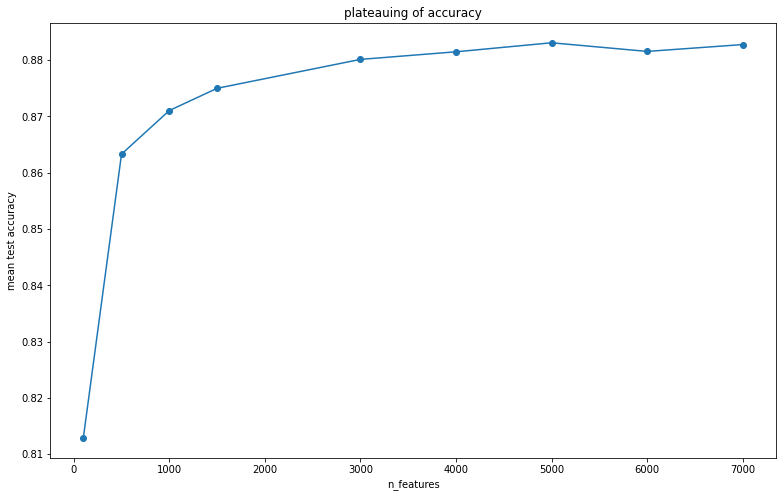

In [24]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(13,8))

plt.xlabel("n_features")
plt.ylabel("mean test accuracy")
plt.title("plateauing of accuracy")

plt.scatter(x = [100,500,1000,1500,3000,4000,5000,6000,7000], y = rff_logreg_gs.cv_results_['mean_test_score'])
plt.plot([100,500,1000,1500,3000,4000,5000,6000,7000],rff_logreg_gs.cv_results_['mean_test_score'])

plt.show()

кажется, что после n_features = 5000 наступает плато


#Бонус

__Задание 4. (Максимум 2 балла)__

Как вы, должно быть, помните с курса МО-1, многие алгоритмы машинного обучения работают лучше, если признаки данных некоррелированы. Оказывается, что для RFF существует модификация, позволяющая получать ортогональные случайные признаки (Orthogonal Random Features, ORF). Об этом методе можно прочитать в [статье](https://proceedings.neurips.cc/paper/2016/file/53adaf494dc89ef7196d73636eb2451b-Paper.pdf). Реализуйте класс для вычисления ORF по аналогии с основным заданием. Обратите внимание, что ваш класс должен уметь работать со случаем n_features > new_dim (в статье есть замечание на этот счет). Проведите эксперименты, сравнивающие RFF и ORF, сделайте выводы.

In [84]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
import numpy as np
from itertools import combinations
# from thundersvm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score



class ORFPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, n_features=1000, new_dim=50, use_PCA=True, classifier_type='logreg', C=1.0):
        """        
        Implements pipeline, which consists of PCA decomposition,
        Random Fourier Features approximation and linear classification model.
        
        n_features, int: amount of synthetic random features generated with RFF approximation.

        new_dim, int: PCA output size.
        
        use_PCA, bool: whether to include PCA preprocessing.
        
        classifier, string: either 'svm' or 'logreg', a linear classification model to use on top of pipeline.
        
        Feel free to edit this template for your preferences.    
        """
        self.n_features = n_features
        self.use_PCA = use_PCA
        self.new_dim = new_dim
        self.classifier_type = classifier_type
        self.C = C

        if (self.classifier_type == 'logreg'):
          self.cls = LogisticRegression(random_state=random_state, n_jobs = -1, C = self.C)
        elif (self.classifier_type == 'svm'):
          self.cls = SVC(kernel = 'linear', random_state=random_state, C = self.C)

        if(self.use_PCA):
          self.pca = PCA(n_components=self.new_dim, random_state=random_state)
        
    def fit(self, X, y):
        """
        Fit all parts of algorithm (PCA, ORF, Classification) to training set.
        """
        if(self.use_PCA):
            X = self.pca.fit_transform(X)

        X_subset = X[np.random.choice(X.shape[0], 1500, replace=False)] # (~1100000 пар)
        sgm = np.sqrt(np.median([np.sum(np.square(x1 - x2)) for (x1, x2) in combinations(X_subset, r = 2)]))

        X_new = None
        self.W_orf_arr = []

        for i in range(self.n_features // X.shape[1] + 1):
          G = np.random.normal(0, 1, size=(X.shape[1], X.shape[1]))
          Q, _ = np.linalg.qr(G)
          S = np.diag(np.sqrt(np.random.chisquare(X.shape[1], size=X.shape[1])))
          W_orf = 1/sgm * S.dot(Q)
          self.W_orf_arr.append(W_orf)

          if i == 0:
            X_new = W_orf.dot(X.T)
          else:
            X_new = np.concatenate((X_new, W_orf.dot(X.T)), axis = 0)


        X_new = X_new[:self.n_features]
        X_new = np.concatenate((np.sin(X_new[:X_new.shape[0]//2]),
                               np.cos(X_new[X_new.shape[0]//2:])), 
                               axis = 0).T

        self.cls.fit(X_new,y)

        return self

    def predict_proba(self, X):
        """
        Apply pipeline to obtain scores for input data.
        """
        if(self.use_PCA):
            X = self.pca.transform(X)

        X_new = None
    
        for i in range(len(self.W_orf_arr)):
          if i == 0:
            X_new = self.W_orf_arr[i].dot(X.T)
          else:
            X_new = np.concatenate((X_new, self.W_orf_arr[i].dot(X.T)), axis = 0)

        X_new = X_new[:self.n_features]
        X_new = np.concatenate((np.sin(X_new[:X_new.shape[0]//2]),
                               np.cos(X_new[X_new.shape[0]//2:])), 
                               axis = 0).T

        return(self.cls.predict_proba(X_new))
        
    def predict(self, X):
        """
        Apply pipeline to obtain discrete predictions for input data.
        """
        if(self.use_PCA):
            X = self.pca.transform(X)

        X_new = None
    
        for i in range(len(self.W_orf_arr)):
          if i == 0:
            X_new = self.W_orf_arr[i].dot(X.T)
          else:
            X_new = np.concatenate((X_new, self.W_orf_arr[i].dot(X.T)), axis = 0)

        X_new = X_new[:self.n_features]
        X_new = np.concatenate((np.sin(X_new[:X_new.shape[0]//2]),
                               np.cos(X_new[X_new.shape[0]//2:])), 
                               axis = 0).T

        return(self.cls.predict(X_new))

In [85]:
orf = ORFPipeline()
orf.fit(x_train, y_train)

ORFPipeline()

In [86]:
print(accuracy_score(y_train, orf.predict(x_train)))
print(accuracy_score(y_test, orf.predict(x_test)))

0.87725
0.8616


In [32]:
rff = RFFPipeline()
rff.fit(x_train, y_train)

RFFPipeline()

In [34]:
print(accuracy_score(y_train, rff.predict(x_train)))
print(accuracy_score(y_test, rff.predict(x_test)))

0.8863166666666666
0.8661


rff показывает качество выше, чем orf

видимо, реализация orf неверная

__Задание 5. (Максимум 2 балла)__

Поэкспериментируйте с функциями для вычисления новых случайных признаков. Не обязательно использовать косинус от скалярного произведения — можно брать знак от него, хэш и т.д. Придумайте побольше вариантов для генерации признаков и проверьте, не получается ли с их помощью добиваться более высокого качества. Также можете попробовать другой классификатор поверх случайных признаков, сравните результаты.

In [ ]:
# Your code here: (￣▽￣)/♫•*¨*•.¸¸♪